# Machine Learning

## 0. Setup

In [1]:
# Import core libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import statistical utilities
from scipy import stats

# Import machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    silhouette_score, adjusted_rand_score,
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [2]:
# Load the processed dataset exported from the previous notebook
df = pd.read_csv("/content/traveltide_user_agg_features.csv")

In [3]:
# Display all columns for inspection
pd.set_option("display.max_columns", None)

In [4]:
df.shape

(5998, 65)

In [5]:
df.head()

,user_id,total_sessions,first_session,last_session,total_trips_booked,total_trips_canceled,total_flights_booked,avg_seats,avg_checked_bags,total_domestic_flights,total_international_flights,net_flight_spend_usd,avg_flight_spend_usd,total_flights_discounted,avg_flight_discount_used,total_hotels_booked,avg_nights,avg_rooms,net_hotel_spend_usd,avg_hotel_spend_usd,total_hotels_discounted,avg_hotel_discount_used,total_staycations,birthdate,gender,is_married,has_children,home_country,home_city,home_airport,sign_up_date,age,lifetime,trips_per_session,cancellation_ratio,pct_flights_per_trip,pct_domestic_flights,pct_international_flights,pct_discounted_flights,pct_hotels_per_trip,pct_discounted_hotels,pct_staycations,ltv_usd,recency_days,lifespan_days,frequency_trips_per_day,monetary_per_day,R_score,F_score,M_score,RFM_segment_label,trips_per_session_cat,pct_flights_per_trip_cat,pct_hotels_per_trip_cat,pct_domestic_flights_cat,pct_international_flights_cat,pct_discounted_flights_cat,pct_discounted_hotels_cat,avg_flight_discount_used_cat,avg_hotel_discount_used_cat,avg_nights_cat,avg_rooms_cat,avg_seats_cat,avg_checked_bags_cat,persona
0,23557,8,2023-01-04 19:30:00,2023-07-14 12:37:09.000000,2,0,0,NaN,NaN,0,0,0.000,NaN,0,NaN,2,10.0,1.5,3670.5,1016.25,1,0.175,1,1958-12-08,F,True,False,usa,new york,LGA,2021-07-22,64,2,0.250000,0.0,0.0,NaN,NaN,NaN,1.0,0.5,0.5,3670.500,14,190,0.010526,19.318421,5,4,2,Potential,Mid-low,Low,Mid-low,NaN,NaN,NaN,High,NaN,High,High,High,NaN,NaN,Riley – Potential – Aspiring globetrotter
1,94883,7,2023-01-10 12:20:00,2023-05-28 17:28:23.000000,1,0,1,1.0,1.0,1,0,240.920,240.9200,0,NaN,1,1.0,1.0,130.0,130.00,0,0.100,0,1972-03-16,F,True,False,usa,kansas city,MCI,2022-02-07,51,1,0.142857,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,370.920,61,138,0.007246,2.687826,2,5,5,At Risk,Low,Mid-low,Mid-low,Low,Low,Low,Low,NaN,Mid-low,Low,Low,Low,Mid-high,Leo – At Risk – Budget short-trip traveler
2,101486,8,2023-01-21 08:02:00,2023-07-18 09:35:22.000000,2,0,1,1.0,0.0,1,0,189.910,189.9100,0,0.075,2,4.0,1.5,2199.0,739.50,0,NaN,0,1972-12-07,F,True,True,usa,tacoma,TCM,2022-02-17,50,1,0.250000,0.0,0.5,1.0,0.0,0.0,1.0,0.0,0.0,2388.910,10,178,0.011236,13.420843,5,4,3,Potential,Mid-low,Low,Mid-low,Low,Low,Low,Low,Low,NaN,Mid-high,High,Low,Low,Riley – Potential – Aspiring globetrotter
3,101961,8,2023-01-19 03:38:00,2023-06-22 13:30:01.000000,5,0,5,1.0,0.4,5,0,1237.693,247.5386,1,0.150,5,3.8,1.0,2429.0,485.80,0,0.100,0,1980-09-14,F,True,False,usa,boston,BOS,2022-02-17,42,1,0.625000,0.0,1.0,1.0,0.0,0.2,1.0,0.0,0.0,3666.693,36,154,0.032468,23.809695,3,1,2,Potential,High,Mid-low,Mid-low,Low,Low,Mid-high,Low,Mid-high,Mid-low,Mid-high,Low,Low,Mid-low,Riley – Potential – Aspiring globetrotter
4,106907,8,2023-01-10 17:24:00,2023-07-27 11:05:14.320529,1,1,1,6.0,5.0,0,1,0.000,13902.0600,0,NaN,1,11.0,3.0,0.0,1419.00,0,NaN,0,1978-11-17,F,True,True,usa,miami,TNT,2022-02-24,44,1,0.125000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000,1,197,0.000000,0.000000,5,5,5,Champions,Low,Mid-low,Mid-low,Low,High,Low,Low,NaN,NaN,High,High,High,High,Alex – Champion – Young global explorer


## 1. Data preprocessing

In [6]:
# Select quantitative behavioral and value-based features for clustering
X = df[[
    'recency_days', 'frequency_trips_per_day', 'monetary_per_day',
    'trips_per_session', 'pct_flights_per_trip', 'pct_hotels_per_trip',
    'pct_domestic_flights', 'pct_international_flights',
    'pct_discounted_flights', 'pct_discounted_hotels',
    'avg_flight_discount_used', 'avg_hotel_discount_used',
    'avg_nights', 'avg_rooms', 'avg_seats', 'avg_checked_bags'
]]

# Persona labels (used later for evaluation and interpretation only)
y = df['persona']

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   recency_days               5998 non-null   int64  
 1   frequency_trips_per_day    5998 non-null   float64
 2   monetary_per_day           5998 non-null   float64
 3   trips_per_session          5998 non-null   float64
 4   pct_flights_per_trip       5471 non-null   float64
 5   pct_hotels_per_trip        5471 non-null   float64
 6   pct_domestic_flights       5071 non-null   float64
 7   pct_international_flights  5071 non-null   float64
 8   pct_discounted_flights     5071 non-null   float64
 9   pct_discounted_hotels      5296 non-null   float64
 10  avg_flight_discount_used   4615 non-null   float64
 11  avg_hotel_discount_used    3948 non-null   float64
 12  avg_nights                 5296 non-null   float64
 13  avg_rooms                  5296 non-null   float

In [8]:
# Replace NaNs caused by valid zero denominators (e.g., users with no hotels or flights)
X = X.fillna(0)

# Quick sanity check (should be 0)
print("Remaining NaNs in X:", X.isna().sum().sum())

Remaining NaNs in X: 0


In [9]:
# Standardize features to ensure equal weight in distance-based clustering
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print("X shape:", X.shape, "| X_scaled shape:", X_scaled.shape)

X shape: (5998, 16) | X_scaled shape: (5998, 16)


In [10]:
# Detect and remove extreme behavioral outliers using z-scores
z_scores = np.abs(stats.zscore(X_scaled))

# Keep only users within ±3 standard deviations across all features
filtered_mask = (z_scores < 3).all(axis=1)
X_scaled_filtered = X_scaled[filtered_mask]
y_filtered = y[filtered_mask]

removed = len(X_scaled) - len(X_scaled_filtered)
removed_pct = removed / len(X_scaled) * 100
print(f"Removed {removed} users as outliers ({removed_pct:.1f}%).")

Removed 971 users as outliers (16.2%).


#### Notes
In this step, I prepared the data for clustering by selecting only the quantitative behavioral and value-based variables.  
Categorical fields, date columns, and predefined segment labels were excluded to ensure that only measurable behavioral patterns influence the analysis.  

Missing values were replaced with `0`, since they represent valid cases (for example, users with no hotel bookings naturally have `pct_hotels_per_trip = 0`).  
All features were standardized using `StandardScaler` to place them on a comparable scale, allowing distance-based models like k-means and DBSCAN to treat every variable fairly.  

Finally, I removed extreme behavioral outliers based on z-scores.  
Any user with feature values beyond ±3 standard deviations was excluded, eliminating approximately **16.2%** of the dataset.  
This filtering step helps the clustering algorithms capture the main behavioral trends instead of being skewed by a few highly irregular users.

## 2. Dimensionality reduction (PCA)

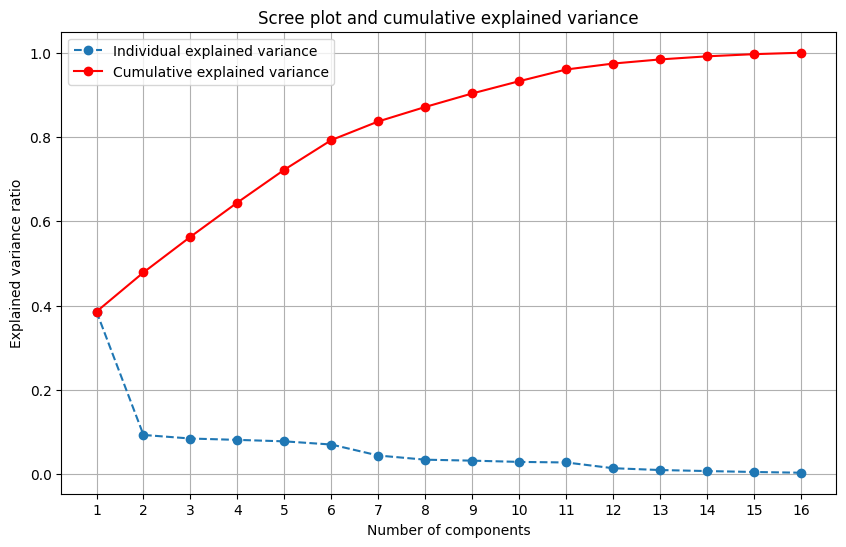

In [11]:
# Apply PCA to the scaled data
pca = PCA()
pca.fit(X_scaled_filtered)

# Explained variance for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance across components
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plot the scree plot (individual variance) and cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    marker='o',
    linestyle='--',
    label='Individual explained variance'
)
plt.plot(
    range(1, len(explained_variance_ratio) + 1),
    cumulative_explained_variance,
    marker='o',
    linestyle='-',
    color='red',
    label='Cumulative explained variance'
)
plt.title('Scree plot and cumulative explained variance')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.legend()
plt.show()

#### Notes
Principal component analysis (PCA) was applied to evaluate redundancy among the standardized behavioral features and to explore whether a reduced-dimensional space could summarize the main user patterns.  

The scree plot shows that variance declines gradually across components, indicating that user behavior depends on many independent factors rather than a few dominant dimensions.  
Reducing the data to only two or three components would oversimplify the variability in how users travel, spend, and engage with the platform.  

Using around **8 components** captures approximately **87%** of the total variance, which is acceptable for visualization or exploratory clustering.  
However, for the main clustering analysis, I retained the **full standardized feature set (`X_scaled_filtered`)** to preserve interpretability and the full behavioral richness of the data.

In [12]:
# Option 1: Keep all features
X_cluster = X_scaled_filtered.copy()

# Option 2: Moderate dimensionality reduction (e.g. 8 components ≈ 80% variance)
pca_8 = PCA(n_components=8, random_state=42)
X_pca_8 = pca_8.fit_transform(X_scaled_filtered)

print(f"Variance explained by 8 components: {pca_8.explained_variance_ratio_.sum():.2f}")

Variance explained by 8 components: 0.87


## 3. Clustering on full feature space

### 1. K-Means model setup

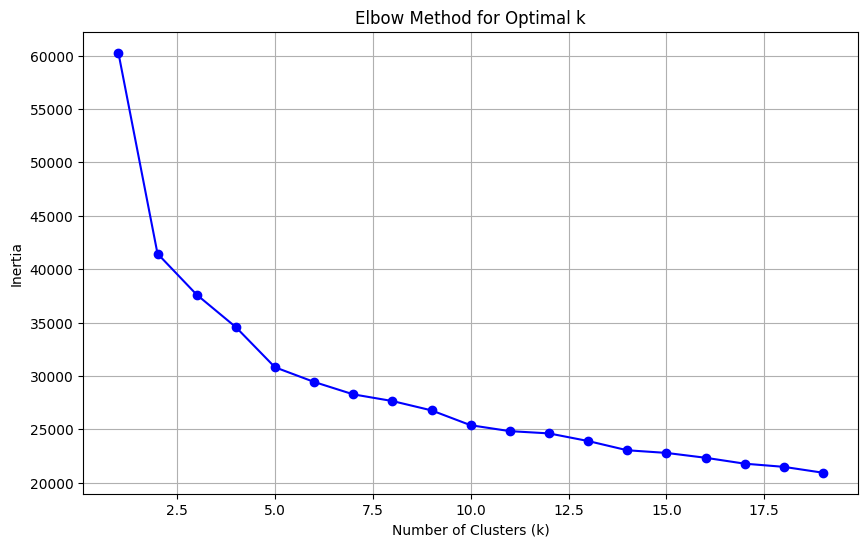

In [13]:
inertia = []
k_range = range(1, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [14]:
# Based on the elbow plot, the optimal range is around k=5.
optimal_k = 5

# Apply K-means clustering directly on the standardized features
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster)

# Create a DataFrame with the cluster assignments
X_scaled_with_clusters = pd.DataFrame(X_cluster, columns=X.columns)
X_scaled_with_clusters['Cluster'] = cluster_labels

In [15]:
# Check cluster sizes
X_scaled_with_clusters['Cluster'].value_counts()

,count
Cluster,
2,1614
1,1339
0,1295
4,513
3,266


#### Notes
K-Means clustering was applied directly to the full standardized behavioral dataset (`X_scaled_filtered`).  
The **elbow method** was used to identify a suitable number of clusters by plotting the inertia (within-cluster sum of squares) across a range of `k` values.  

The curve shows an inflection point around **k = 5**, after which the improvement in cluster compactness diminishes.  
This suggests that **five clusters** may be sufficient to capture the main behavioral patterns while avoiding over-partitioning the user base.

### 2. K-Means model evaluation

In [16]:
# Silhouette score to measure cohesion and separation
sil_score = silhouette_score(X_cluster, cluster_labels)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.178


In [17]:
# Adjusted Rand Index to measure alignment with predefined personas
ari = adjusted_rand_score(y_filtered, cluster_labels)
print(f"Adjusted Rand Index (vs personas): {ari:.3f}")

Adjusted Rand Index (vs personas): 0.106


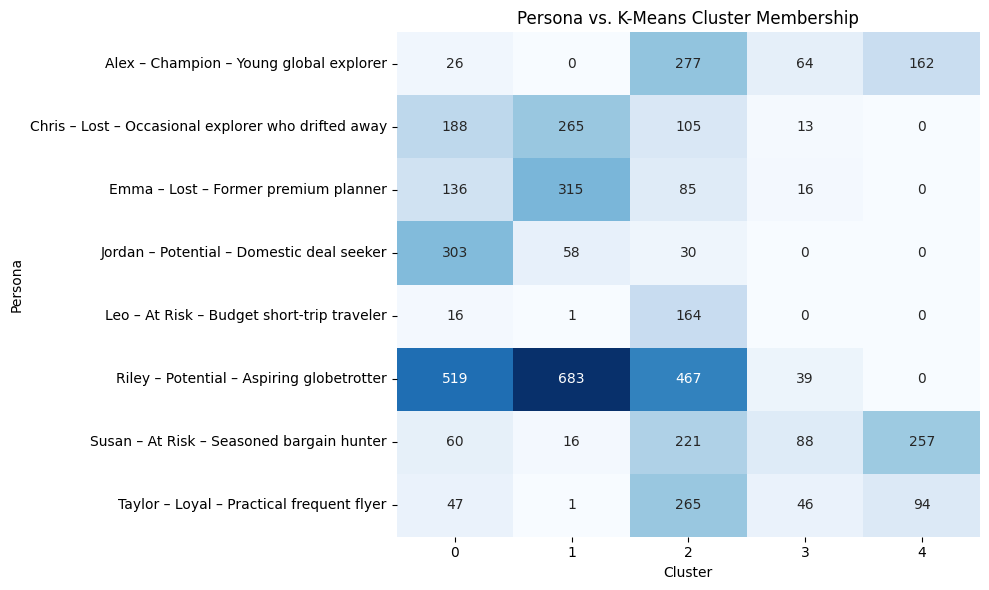

In [18]:
# Confusion matrix to visualize overlap between K-Means clusters and personas
conf_mat = pd.crosstab(y_filtered, cluster_labels, rownames=['Persona'], colnames=['Cluster'])

# Plot as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='d', cbar=False)
plt.title('Persona vs. K-Means Cluster Membership')
plt.ylabel('Persona')
plt.xlabel('Cluster')
plt.tight_layout()
plt.show()

#### Notes
To assess clustering quality, three complementary evaluation methods were applied: **Silhouette score** , **Adjusted Rand Index (ARI)**, and a **confusion matrix**.

The evaluation results show that, even after removing outliers, K-Means produces clusters that are **not well-separated** in the multidimensional behavioral space:  
- **Silhouette Score: 0.178** → indicates high overlap among clusters and limited internal cohesion.  
- **Adjusted Rand Index: 0.106** → shows minimal alignment between the K-Means clusters and the conceptually defined personas.

The confusion matrix heatmap confirms that personas are spread across several clusters, suggesting that user travel behavior follows **continuous gradients rather than forming distinct boundaries**.  
While K-Means provides a structural overview of user similarities, it falls short of isolating clear behavioral segments.

### 3. DBSCAN model

In [19]:
# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10)  # eps controls neighborhood size
db_labels = dbscan.fit_predict(X_cluster)

# Add cluster labels to a copy of the dataset
X_db = X_cluster.copy()
X_db['Cluster'] = db_labels

# Display number of users per cluster, including noise (-1)
print(X_db['Cluster'].value_counts().sort_index())

# Compute silhouette score, excluding noise points (-1)
mask = db_labels != -1
if mask.sum() > 0:
    sil_dbscan = silhouette_score(X_cluster[mask], db_labels[mask])
    print(f"Silhouette Score (DBSCAN): {sil_dbscan:.3f}")
else:
    print("All points classified as noise. Adjust eps or min_samples.")

Cluster
-1    1558
 0    2735
 1     513
 2     179
 3      22
 4      20
Name: count, dtype: int64
Silhouette Score (DBSCAN): 0.343


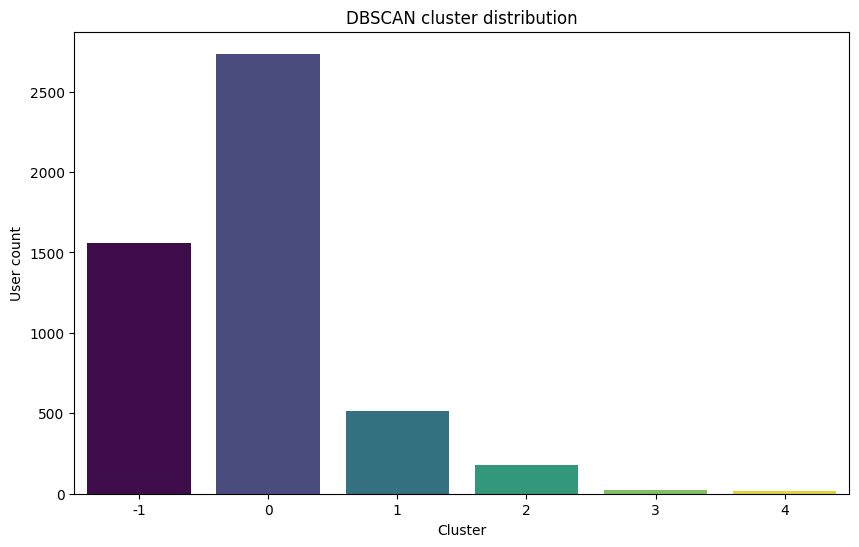

In [28]:
# Plot cluster distribution (fixing seaborn warning by setting hue=x and legend=False)
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='Cluster', data=X_db, palette='viridis', legend=False,
              order=sorted(X_db['Cluster'].unique()))
plt.title('DBSCAN cluster distribution')
plt.xlabel('Cluster')
plt.ylabel('User count')
plt.show()

#### Notes
DBSCAN was applied to uncover clusters of varying density and identify potential noise points representing atypical or inconsistent behaviors.

- **eps = 1.5** defines the neighborhood radius, determining how close users must be in the feature space to belong to the same cluster.  
- **min_samples = 10** ensures each cluster includes at least ten users, preventing spurious micro-clusters.  

The resulting structure identifies six total groups (including noise):  
- **Cluster 0** dominates with around **54% of users (2735 of 5027)**, while several smaller, denser pockets capture more specific behavioral patterns.  
- **Noise (-1)** represents roughly **31% of users (1558 of 5027)**, a substantial but acceptable proportion for DBSCAN, which intentionally isolates users who don’t exhibit consistent patterns.  

The **Silhouette Score (0.343)** marks a clear improvement over K-Means (0.178), showing that DBSCAN forms **tighter and better-separated clusters**.  
This suggests TravelTide’s user behavior is **non-spherical and unevenly distributed**, confirming that **density-based methods capture its complexity more effectively than centroid-based ones**.

### 4. Business insights from the unsipervised machine learning approach

The machine learning clustering approaches proved informative but not highly productive for TravelTide’s data structure.  

**K-Means** performed poorly, with low separation and overlapping user behaviors, while **DBSCAN** provided clearer groupings but required excluding both outliers and noise to produce stable results.  
This filtering process, while methodologically valid, significantly reduces the number of users included in the analysis and limits generalization.

Even after clustering, each group would still require a **manual interpretation step** similar to the descriptive statistics approach.  
That earlier method, based on well-defined behavioral metrics such as RFM scores, offers **greater control and business relevance**, making it easier to describe and act upon user segments.

Still, the ML approach offers an important conceptual insight:  
travel behavior is **not cleanly separable into distinct clusters**. Overlaps and blurred boundaries between users are inherent to how people plan and book travel.  

In practice, the most valuable next step would be to **validate any clustering approach through real-world campaigns**: testing engagement or retention responses by cluster.  
Alternatively, developing a **supervised model** could provide stronger predictive power, enabling TravelTide to classify both past and future users into meaningful behavioral categories with higher consistency.

## 5. Supervised machine learning approach

### 1. Random forest

Accuracy: 0.931

Classification report:
                                                     precision    recall  f1-score   support

            Alex – Champion – Young global explorer       0.98      0.99      0.98       135
Chris – Lost – Occasional explorer who drifted away       0.97      0.84      0.90       138
               Emma – Lost – Former premium planner       0.86      0.98      0.92       130
          Jordan – Potential – Domestic deal seeker       0.82      0.63      0.71        86
         Leo – At Risk – Budget short-trip traveler       0.91      0.98      0.94        41
          Riley – Potential – Aspiring globetrotter       0.91      0.97      0.94       390
          Susan – At Risk – Seasoned bargain hunter       0.99      0.96      0.97       170
          Taylor – Loyal – Practical frequent flyer       0.98      0.95      0.97       110

                                           accuracy                           0.93      1200
                            

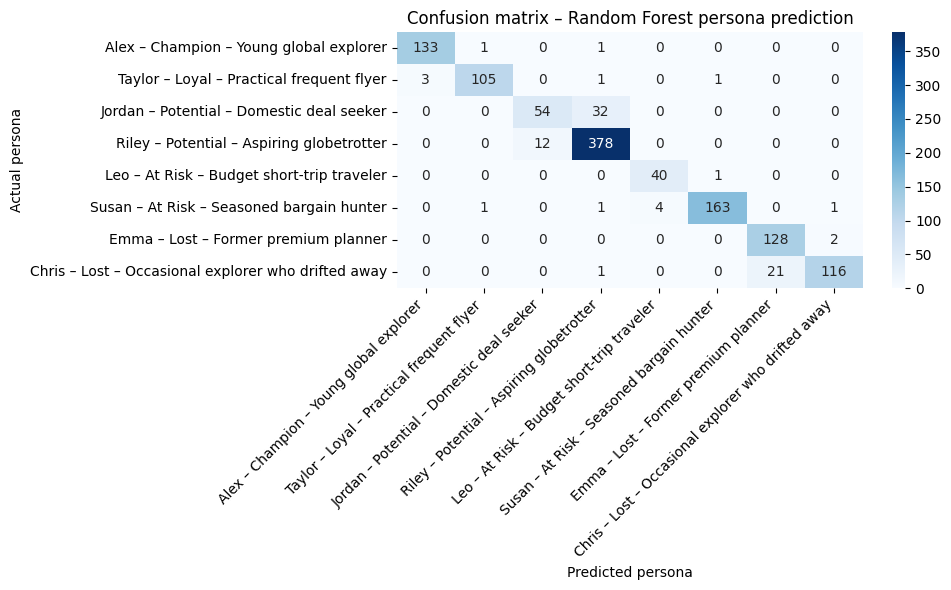

In [29]:
# Select features (same as in clustering)
X = df[[
    'recency_days', 'frequency_trips_per_day', 'monetary_per_day',
    'trips_per_session', 'pct_flights_per_trip', 'pct_hotels_per_trip',
    'pct_domestic_flights', 'pct_international_flights',
    'pct_discounted_flights', 'pct_discounted_hotels',
    'avg_flight_discount_used', 'avg_hotel_discount_used',
    'avg_nights', 'avg_rooms', 'avg_seats', 'avg_checked_bags'
]].fillna(0)

# Target variable
y = df['persona']

# Split into train/test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a simple Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = rf.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# Define custom persona order
persona_order = [
    "Alex – Champion – Young global explorer",
    "Taylor – Loyal – Practical frequent flyer",
    "Jordan – Potential – Domestic deal seeker",
    "Riley – Potential – Aspiring globetrotter",
    "Leo – At Risk – Budget short-trip traveler",
    "Susan – At Risk – Seasoned bargain hunter",
    "Emma – Lost – Former premium planner",
    "Chris – Lost – Occasional explorer who drifted away"
]

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, y_pred, labels=persona_order)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=persona_order,
    yticklabels=persona_order
)
plt.xlabel('Predicted persona')
plt.ylabel('Actual persona')
plt.title('Confusion matrix – Random Forest persona prediction')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Notes  
Trained a random forest classifier to predict personas based on behavioral and value-based features.  
The model achieved **93% accuracy**, showing strong predictive capability and stable generalization.  
Random forests were selected for their ability to capture nonlinear relationships and handle feature interactions without extensive preprocessing.  
Most personas were predicted with high precision and recall, confirming that the manually defined segments are **internally consistent** and data-supported.  
Some overlap appeared between the two “Potential” personas (*Jordan* and *Riley*), which aligns with observed behavioral similarity in booking frequency and travel types.  
While the model is powerful, its complexity limits interpretability, making it better suited for validation and prediction rather than direct marketing application.  

### 2. Decision tree for interpretability

In [22]:
# Use the same structure built for clustering:
# X: numeric feature matrix (before scaling), NaNs already filled with 0
# filtered_mask, y_filtered: from the preprocessing (±3 z-score outlier removal)
X_filtered = X.loc[filtered_mask].copy()
y_filtered = y.loc[filtered_mask].copy()

In [23]:
# Train/validation split (stratified to preserve persona ratios)
Xtr, Xte, ytr, yte = train_test_split(
    X_filtered, y_filtered,
    test_size=0.2, random_state=42, stratify=y_filtered
)

In [24]:
# Decision tree with simple hyperparameter search
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

grid = {
    "max_depth": [3, 4, 5],
    "min_samples_leaf": [200, 300, 500],
    "ccp_alpha": [0.0, 0.0005, 0.001, 0.005]  # minimal cost-complexity pruning
}

cv = GridSearchCV(
    dt, grid, scoring="f1_macro", cv=5, n_jobs=-1, verbose=0
)
cv.fit(Xtr, ytr)

best_dt = cv.best_estimator_
print("Best parameters:", cv.best_params_)

Best parameters: {'ccp_alpha': 0.0, 'max_depth': 3, 'min_samples_leaf': 200}


Accuracy: 0.705765407554672

Classification report:

                                                     precision    recall  f1-score   support

            Alex – Champion – Young global explorer       0.67      0.95      0.79       106
          Taylor – Loyal – Practical frequent flyer       0.72      0.77      0.74        91
          Jordan – Potential – Domestic deal seeker       0.45      0.97      0.61        78
          Riley – Potential – Aspiring globetrotter       0.99      0.58      0.73       342
         Leo – At Risk – Budget short-trip traveler       0.39      0.92      0.55        36
          Susan – At Risk – Seasoned bargain hunter       1.00      0.47      0.64       129
               Emma – Lost – Former premium planner       0.67      0.75      0.71       110
Chris – Lost – Occasional explorer who drifted away       0.74      0.76      0.75       114

                                           accuracy                           0.71      1006
               

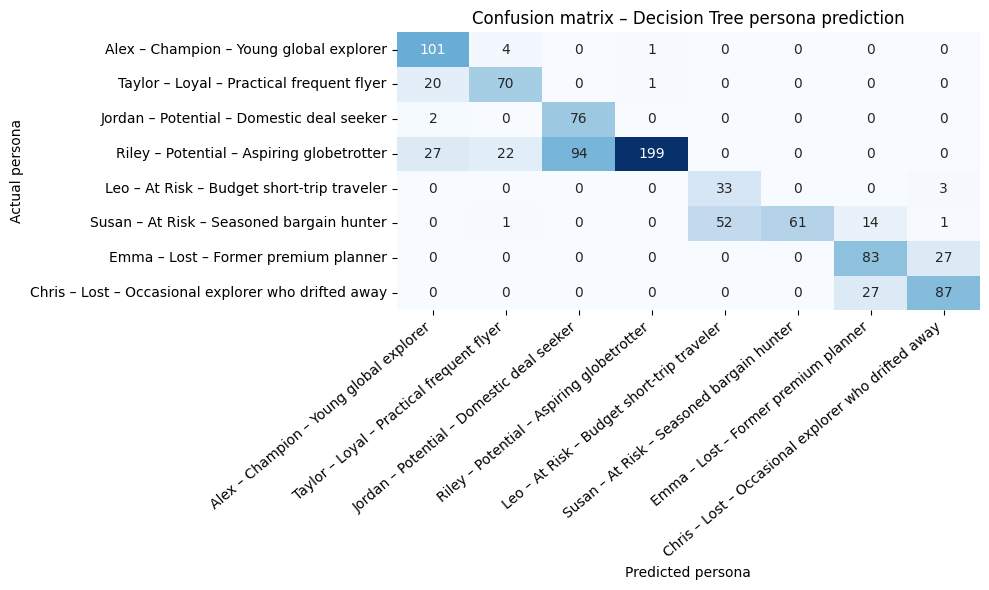

In [30]:
# Evaluation: report + confusion matrix
y_pred = best_dt.predict(Xte)

print("Accuracy:", (y_pred == yte).mean())
print("\nClassification report:\n")
print(classification_report(yte, y_pred, target_names=persona_order, labels=persona_order))

cm = confusion_matrix(yte, y_pred, labels=persona_order)
cm_df = pd.DataFrame(cm, index=persona_order, columns=persona_order)

plt.figure(figsize=(10, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion matrix – Decision Tree persona prediction")
plt.xlabel("Predicted persona")
plt.ylabel("Actual persona")
plt.xticks(rotation=40, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

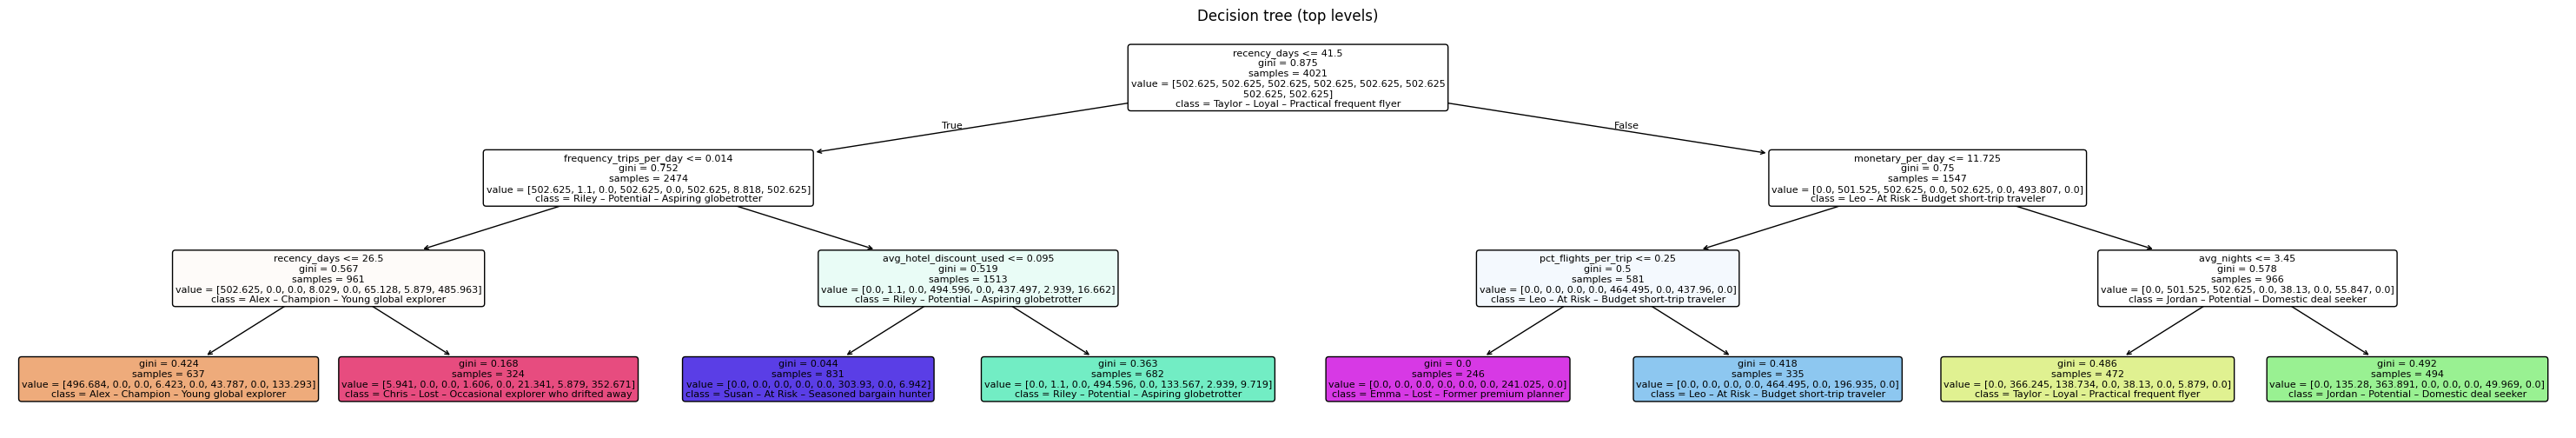

|--- recency_days <= 41.50
|   |--- frequency_trips_per_day <= 0.01
|   |   |--- recency_days <= 26.50
|   |   |   |--- class: Alex – Champion – Young global explorer
|   |   |--- recency_days >  26.50
|   |   |   |--- class: Taylor – Loyal – Practical frequent flyer
|   |--- frequency_trips_per_day >  0.01
|   |   |--- avg_hotel_discount_used <= 0.10
|   |   |   |--- class: Riley – Potential – Aspiring globetrotter
|   |   |--- avg_hotel_discount_used >  0.10
|   |   |   |--- class: Jordan – Potential – Domestic deal seeker
|--- recency_days >  41.50
|   |--- monetary_per_day <= 11.72
|   |   |--- pct_flights_per_trip <= 0.25
|   |   |   |--- class: Susan – At Risk – Seasoned bargain hunter
|   |   |--- pct_flights_per_trip >  0.25
|   |   |   |--- class: Leo – At Risk – Budget short-trip traveler
|   |--- monetary_per_day >  11.72
|   |   |--- avg_nights <= 3.45
|   |   |   |--- class: Chris – Lost – Occasional explorer who drifted away
|   |   |--- avg_nights >  3.45
|   |   |   |--

In [26]:
# Interpretability: visualize a shallow view of the tree and export rules

plt.figure(figsize=(38, 6))
plot_tree(
    best_dt,
    feature_names=X_filtered.columns,
    class_names=persona_order,
    filled=True, rounded=True,
    max_depth=3,  # show top splits only
    fontsize=8
)
plt.title("Decision tree (top levels)")
plt.show()

rules = export_text(best_dt, feature_names=list(X_filtered.columns), max_depth=4)
print(rules)

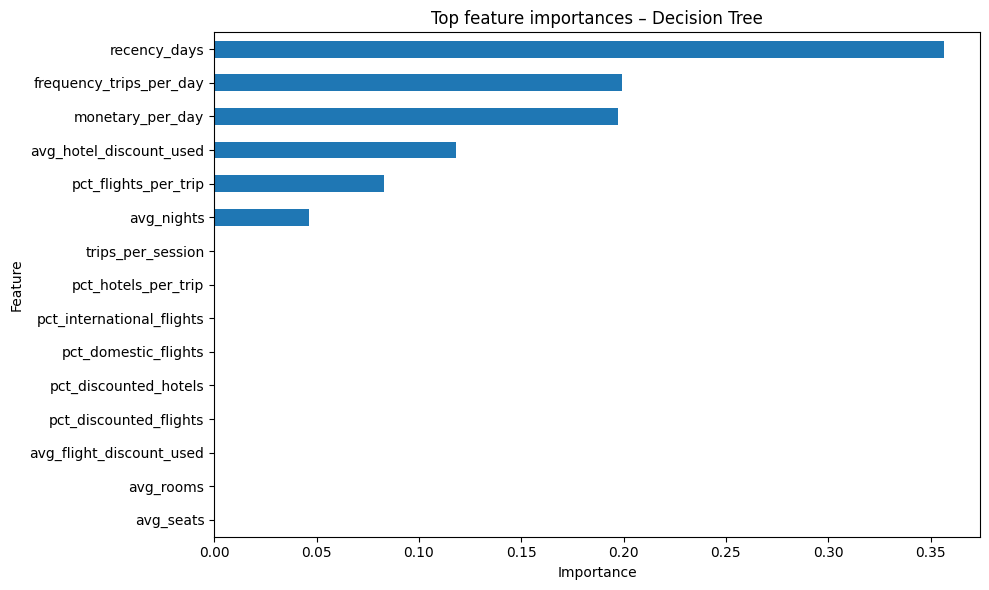

In [31]:
# Feature importance bar chart
importances = pd.Series(best_dt.feature_importances_, index=X_filtered.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top feature importances – Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### Notes  
Trained a decision tree with a limited depth (`max_depth=3`) and a large minimum leaf size (`min_samples_leaf ≥ 200`) to keep results interpretable and business-ready.  
This setup ensured that each resulting group was large enough for campaign activation and avoided over-fitting to micro-behaviors.  
The model reached **~70% accuracy**, which is acceptable given the constraints and confirms that user differentiation can be captured with a few high-level behavioral rules.  

### 3. Business insights from the unsipervised machine learning approach

Supervised machine learning provided a practical validation layer for the manually defined personas while revealing new behavioral nuances.  

- **Random forest** confirmed that the persona framework aligns with measurable user behavior, achieving high predictive accuracy and internal consistency.  
- **Decision tree** translated those behavioral differences into simple, interpretable rules that can guide campaign segmentation and automation.  

Beyond the core RFM metrics (recency, frequency, monetary), the models surfaced complementary dimensions that enrich the understanding of user intent and value sensitivity:  
- **average hotel discount used** → distinguishes deal-seekers from high-value travelers  
- **percentage of flights per trip** → reflects how often users combine flights and hotels  
- **average nights per stay** → separates short-trip planners from longer-term travelers  

These insights highlight that travel behavior is multifaceted and not cleanly separable into rigid clusters, reinforcing the need for **hybrid segmentation**, where manual expertise defines intent and machine learning validates and sharpens it.  

This work serves as a **proof of concept** for an iterative cycle:  
1. Define personas manually based on business logic.  
2. Validate and refine them through supervised models.  
3. Use interpretable decision trees to extract actionable classification rules.  

Iterating this process over time would continuously improve persona accuracy, enabling more precise targeting, better retention campaigns, and ultimately, a tighter feedback loop between data and marketing strategy.  